In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import re

from string import punctuation
from nltk.corpus import stopwords
from wordcloud import WordCloud 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay#, plot_roc_curve, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy import sparse

In [10]:
# nltk.download('stopwords')
# nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Оля\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [18]:
def read_data(file_name):
    lines = []
    with open(file_name, encoding='utf-8') as file:
        lines = [line.strip() for line in file if len(line.strip()) > 0]
    return lines

clickbates_data = read_data('./data/clickbait_data')
non_clickbates_data = read_data('./data/non_clickbait_data')
print(len(clickbates_data), len(non_clickbates_data))

15999 16001


In [19]:
# create DataFrames
clickbates = pd.DataFrame(clickbates_data, columns=['headline'])
clickbates['label'] = 1

non_clickbates = pd.DataFrame(non_clickbates_data, columns=['headline'])
non_clickbates['label'] = 0


print(clickbates.head())
print(non_clickbates.head())


                                            headline  label
0                                 Should I Get Bings      1
1      Which TV Female Friend Group Do You Belong In      1
2  The New "Star Wars: The Force Awakens" Trailer...      1
3  This Vine Of New York On "Celebrity Big Brothe...      1
4  A Couple Did A Stunning Photo Shoot With Their...      1
                                            headline  label
0  Bill Changing Credit Card Rules Is Sent to Oba...      0
1  In Hollywood, the Easy-Money Generation Toughe...      0
2  1700 runners still unaccounted for in UK's Lak...      0
3  Yankees Pitchers Trade Fielding Drills for Put...      0
4  Large earthquake rattles Indonesia; Seventh in...      0


Preprocessing data

In [20]:
def preprocess(text):
    result = text.replace('/', '')
    #result = re.sub(r'[1-9]+', 'number ', result) # numbers replaced with 'number'
    result = re.sub(r'(\w)(\1{2,})', r'\1', result) # letters repetition
    result = ''.join(t for t in result if t not in punctuation)
    result = re.sub(r' +', ' ', result).lower().strip() # spaces
    return result

clickbates['headline'] = clickbates['headline'].apply(preprocess)
non_clickbates['headline'] = non_clickbates['headline'].apply(preprocess)

In [21]:
# merge data
merged = pd.concat([clickbates, non_clickbates])
merged = merged.sample(frac = 1)
print(merged.head())

# save preprocessed merged data
with open('./data/preprocessed_merged.pkl','wb') as fp:
     pickle.dump(merged, fp)

                                                headline  label
1779           zimbabwean rivals sign power sharing deal      0
877               what makes carly rae jepsen a pop star      1
11819  we need to talk about how fucking delicious em...      1
5403               who said this tina fey or amy poehler      1
8631             energy trade in east calls for scrutiny      0


Exploratory Data Analysis

In [205]:
# plot word cloud
def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off")

# extract top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return pd.DataFrame(words_freq[:n], columns=['words', 'count']).set_index('words')

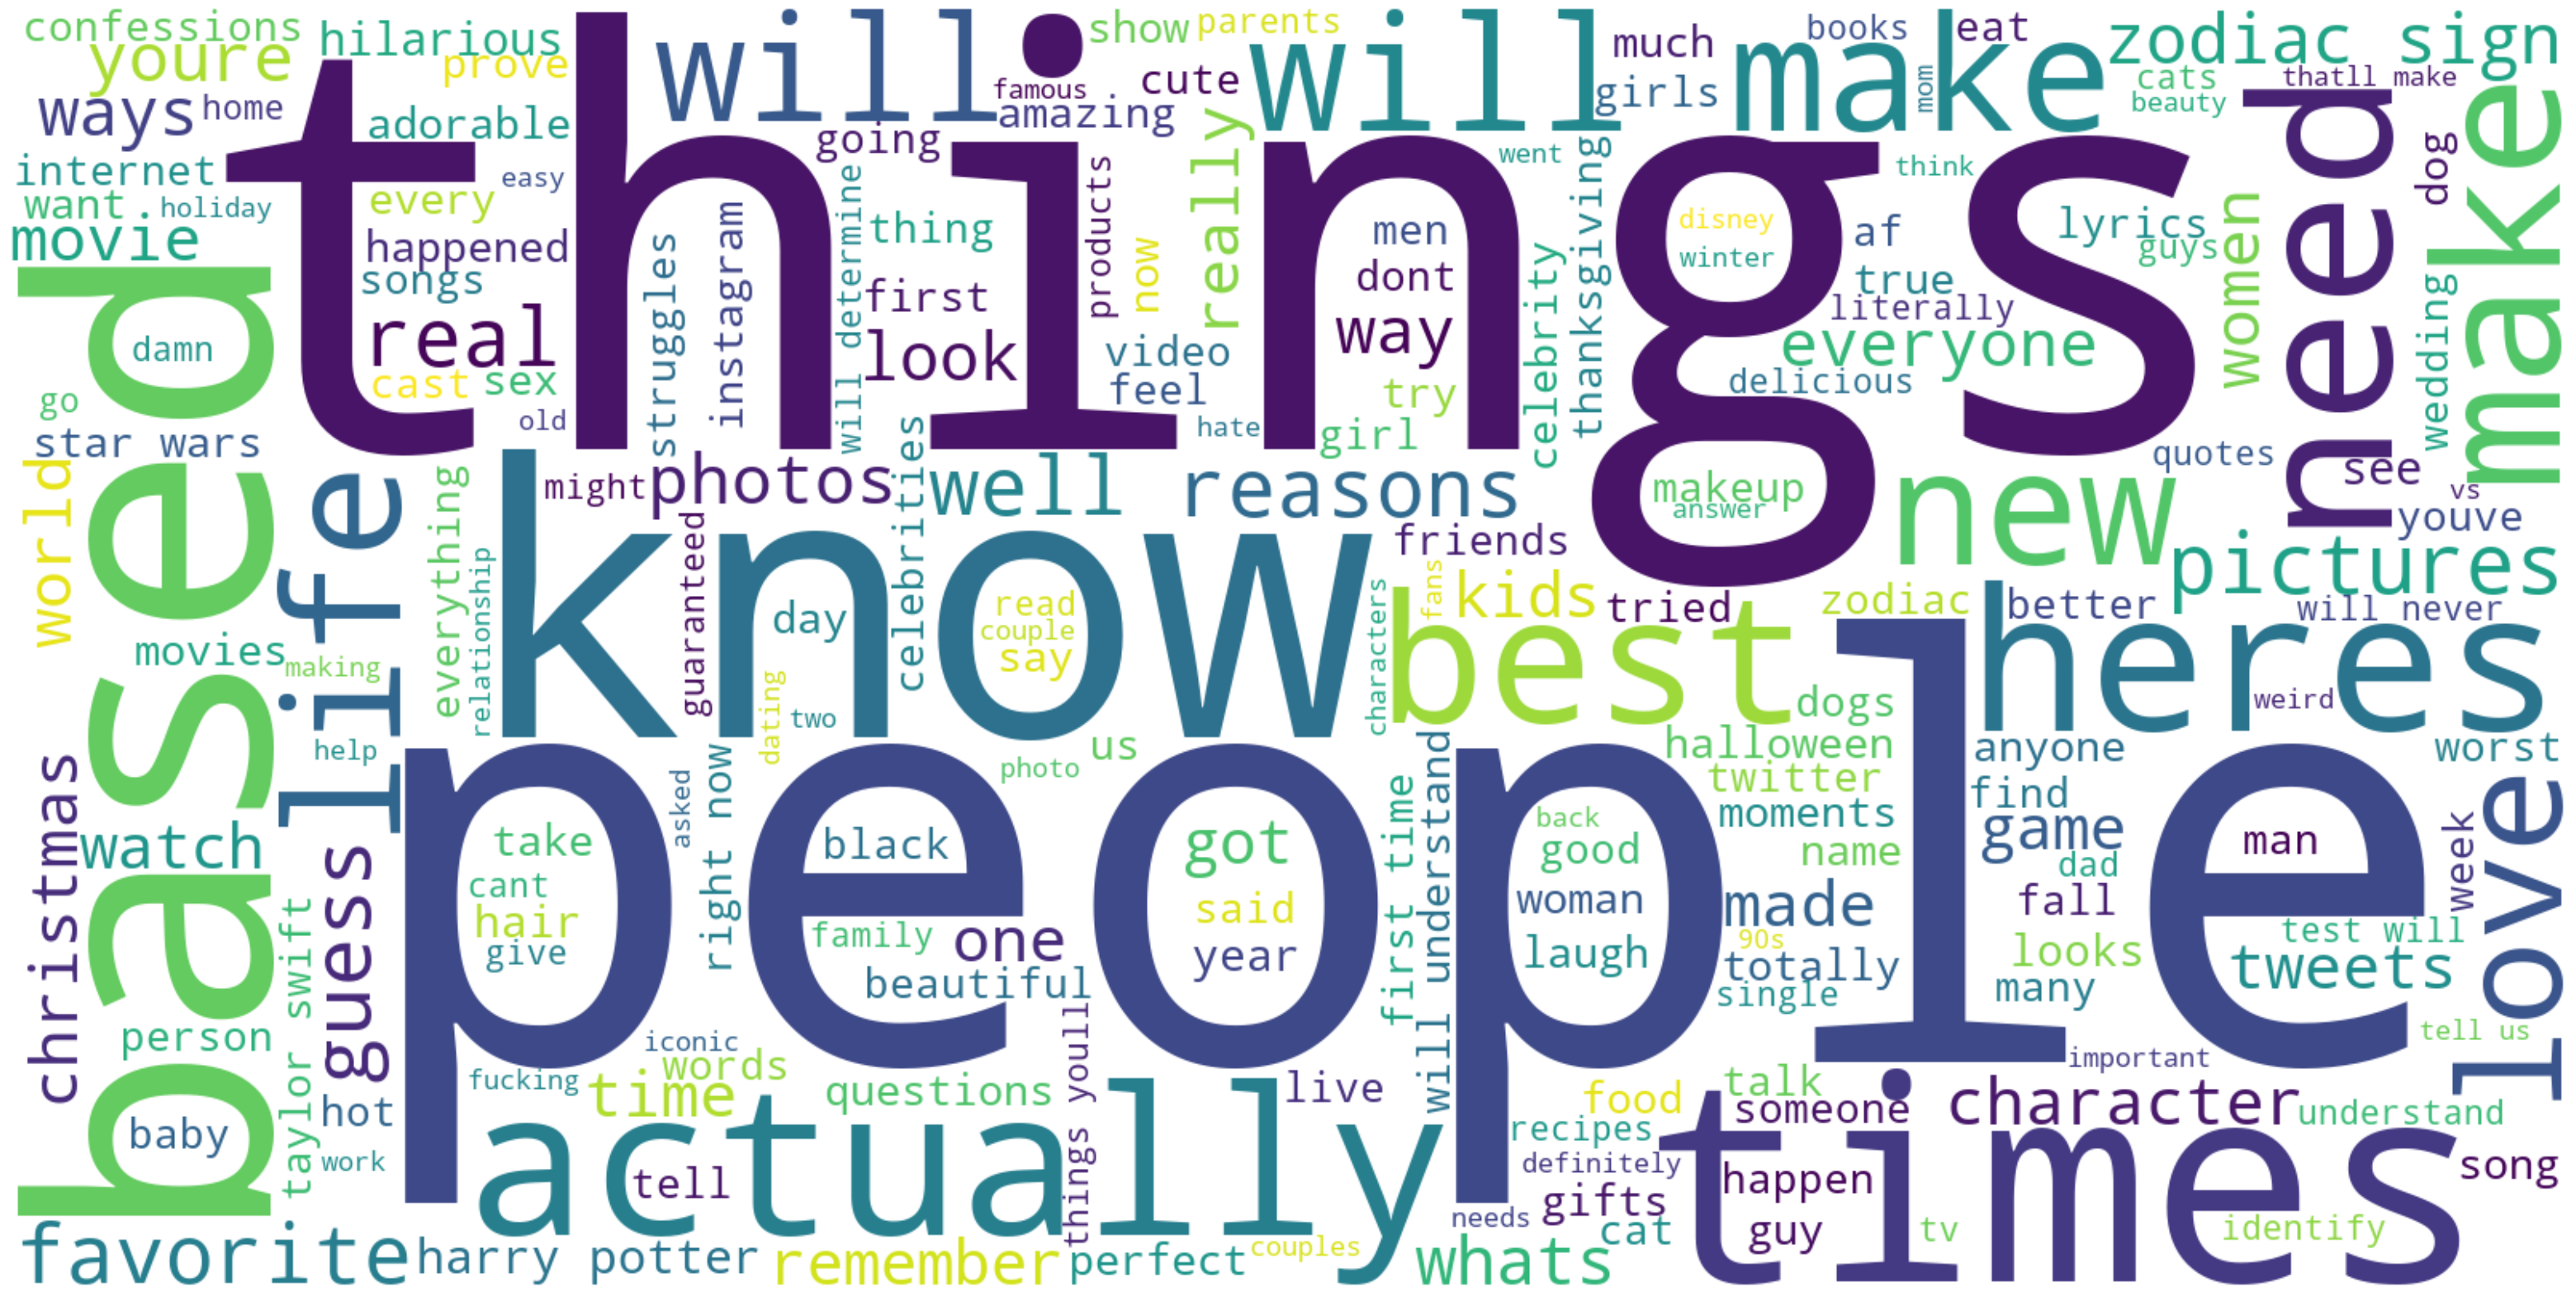

In [206]:
text = " ".join(clickbates['headline'])
wordcloud_cb = WordCloud(background_color="white", width=1600, height=800, normalize_plurals=False).generate(text)

plot_cloud(wordcloud_cb)

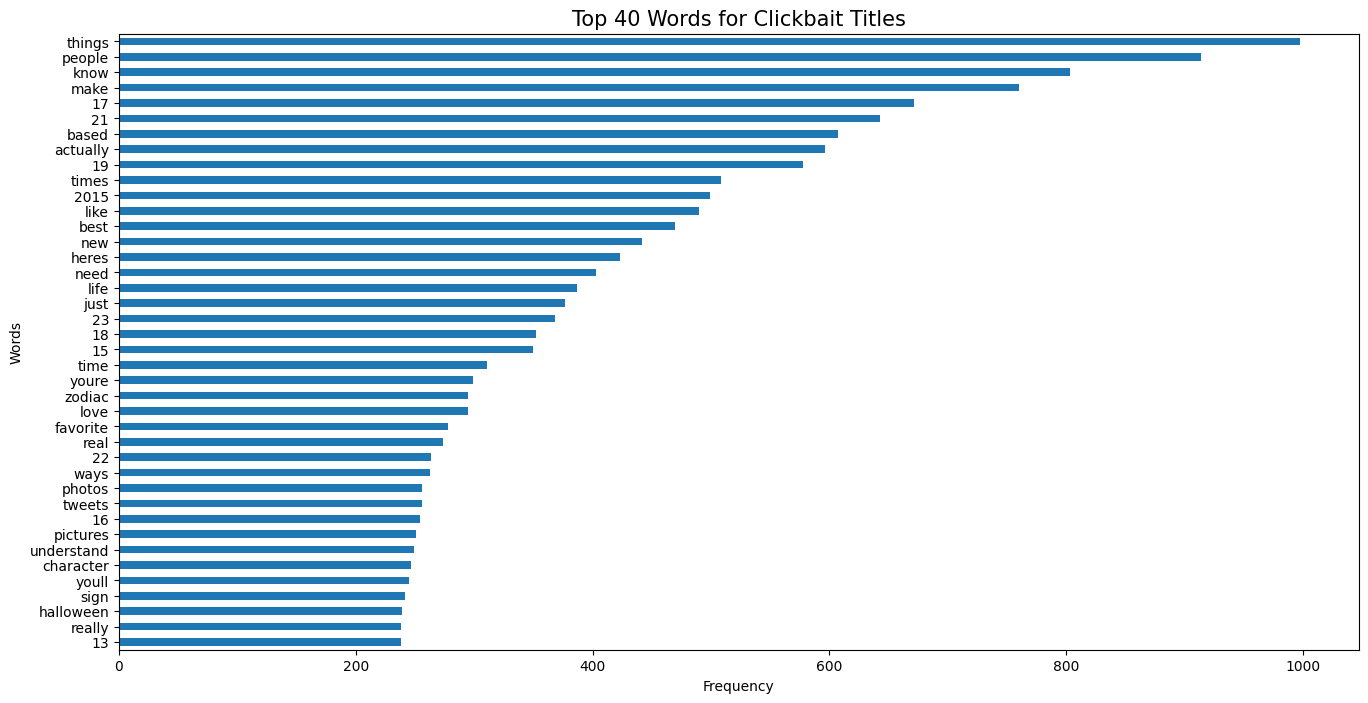

In [11]:
# word frequency into dataframe
words_cb = get_top_n_words(clickbates['headline'], 40)

# top 40 words bar plot
words_cb.plot(kind='barh', figsize=(16,8))
plt.gca().invert_yaxis()
plt.title('Top 40 Words for Clickbait Titles', fontsize=15)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.legend().remove()

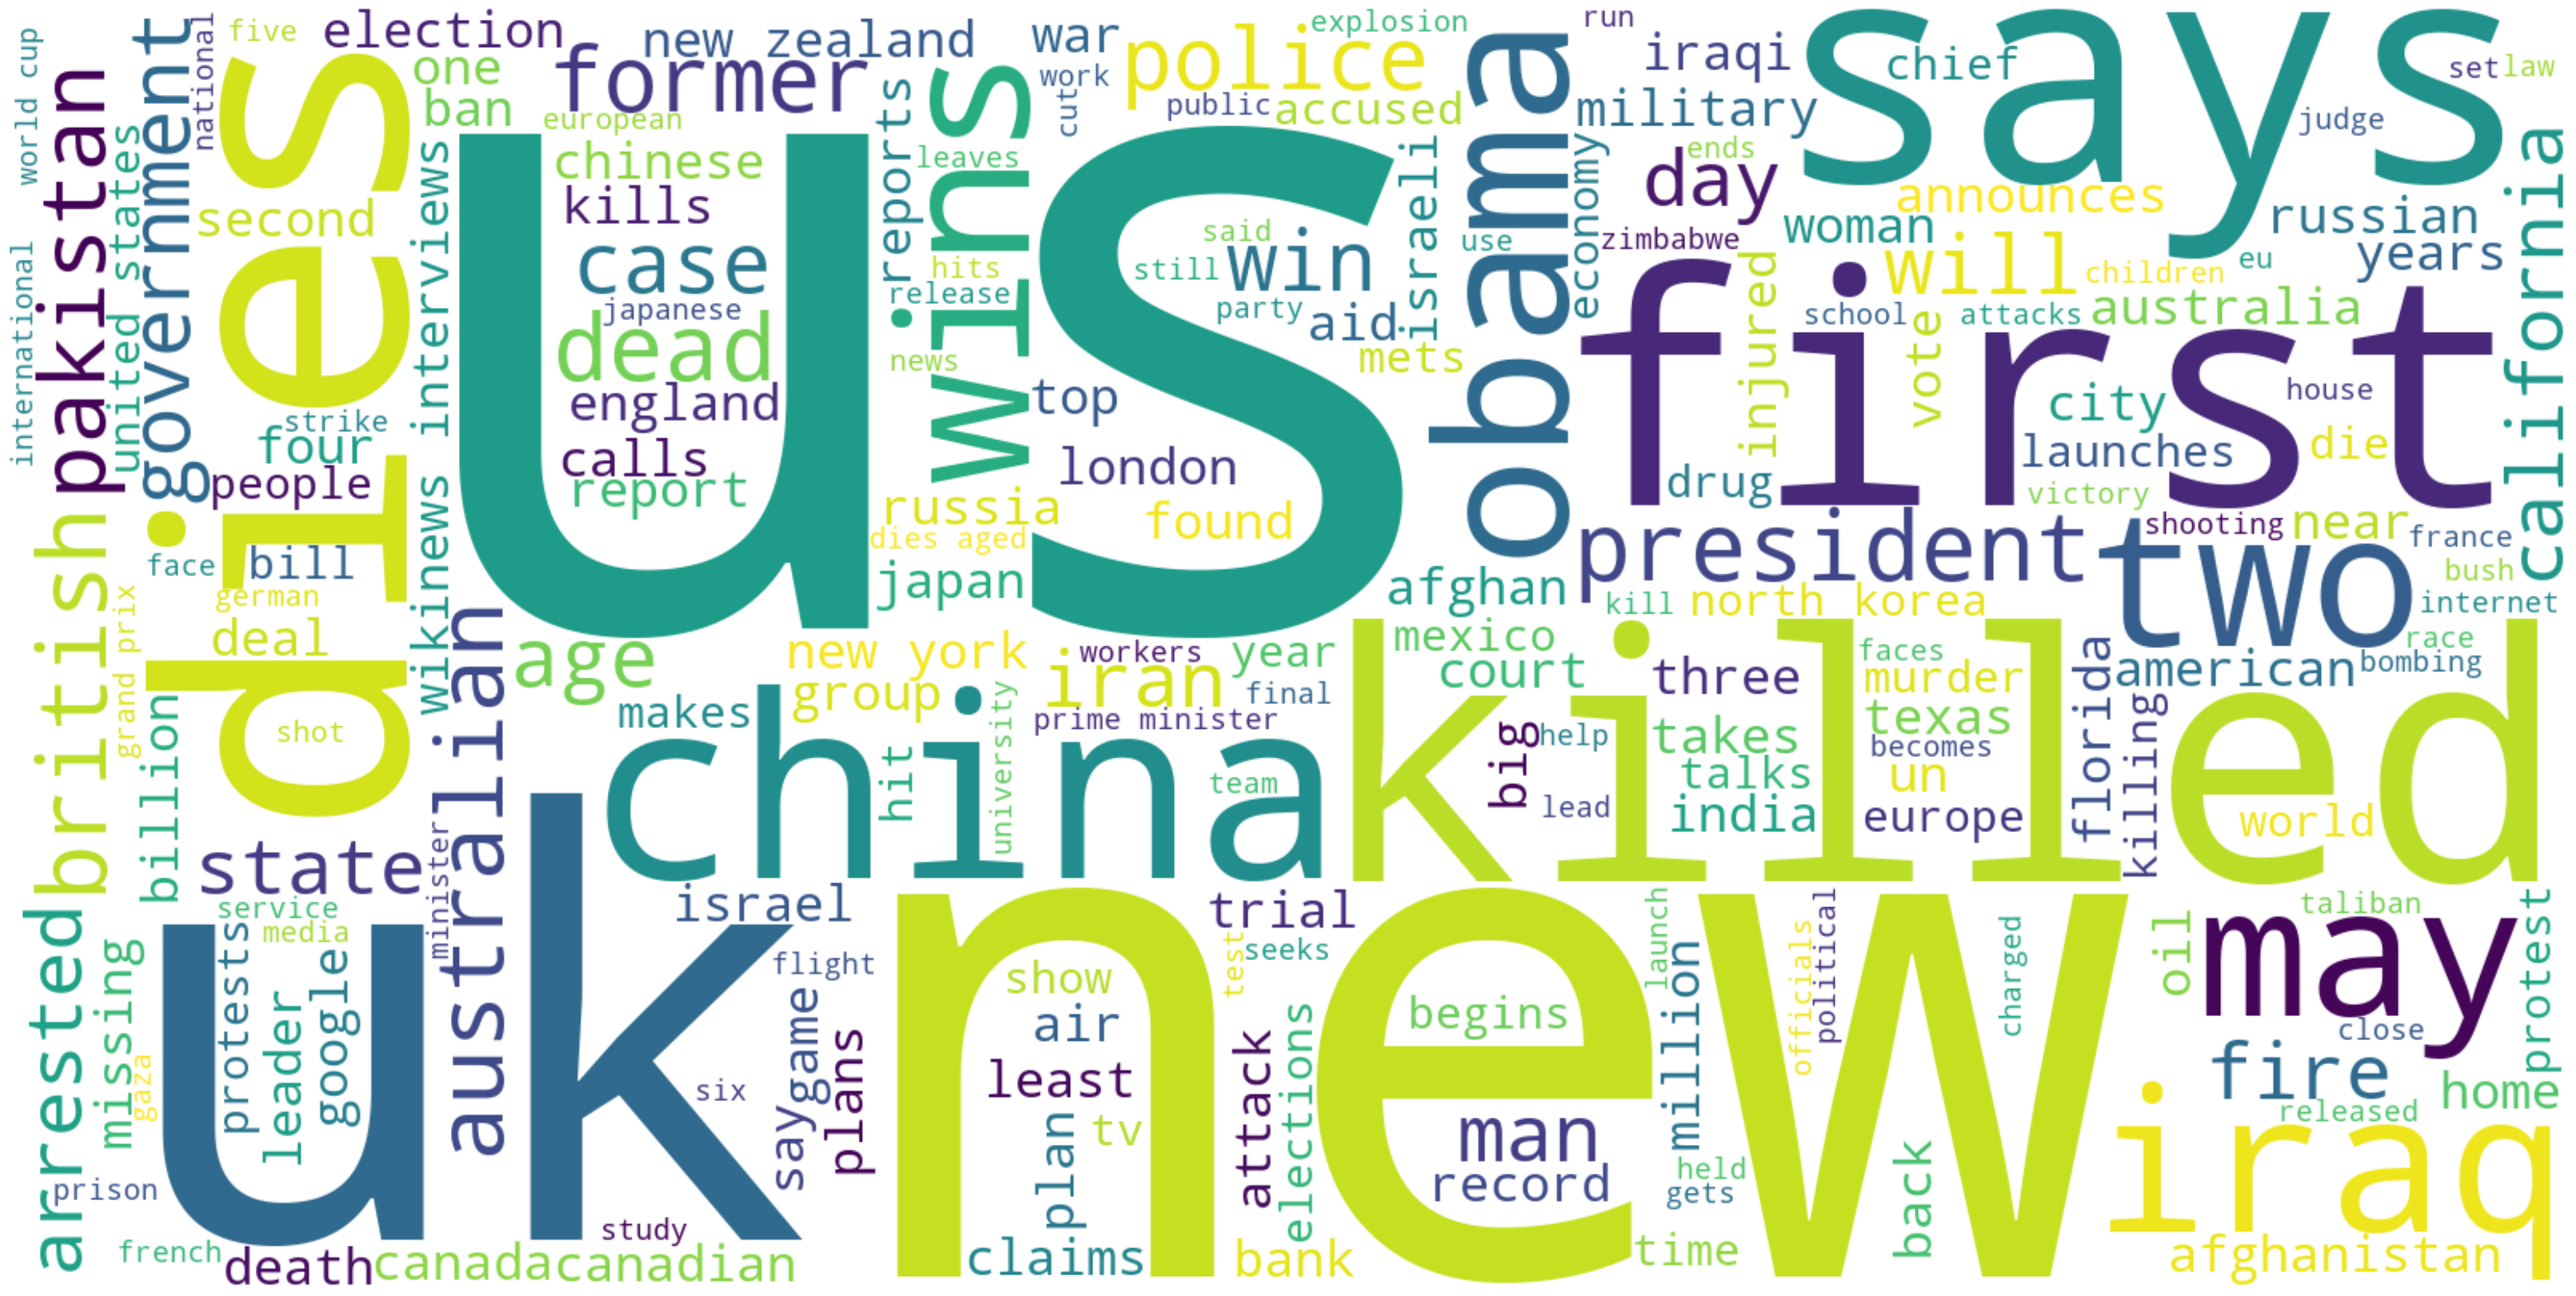

In [12]:
# wordcloud for non-clickbait titles
text = " ".join(non_clickbates['headline'])
wordcloud_non = WordCloud(background_color="white", width=1600, height=800, normalize_plurals=False).generate(text)

plot_cloud(wordcloud_non)

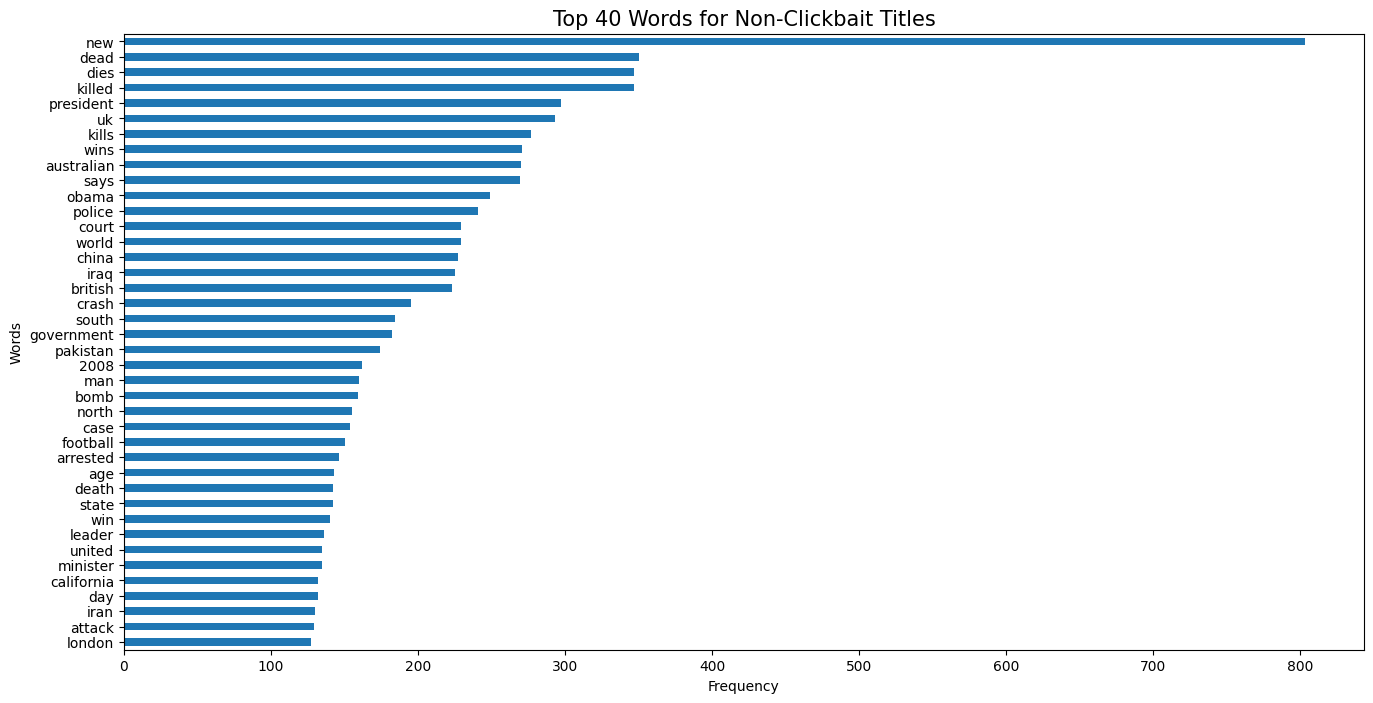

In [13]:
# word frequency into dataframe
words_non = get_top_n_words(non_clickbates['headline'], 40)

# top 40 words using bar plot
words_non.plot(kind='barh', figsize=(16,8))
plt.gca().invert_yaxis()
plt.title('Top 40 Words for Non-Clickbait Titles', fontsize=15)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.legend().remove()

In [23]:
# extract top bigrams
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return pd.DataFrame(words_freq[:n], columns=['bigrams', 'count']).set_index('bigrams')

In [24]:
# extract the top 40 bigrams for clickbait and non-clickbait
bigrams_cb = get_top_n_bigram(clickbates['headline'], 30)
bigrams_non = get_top_n_bigram(non_clickbates['headline'], 30)

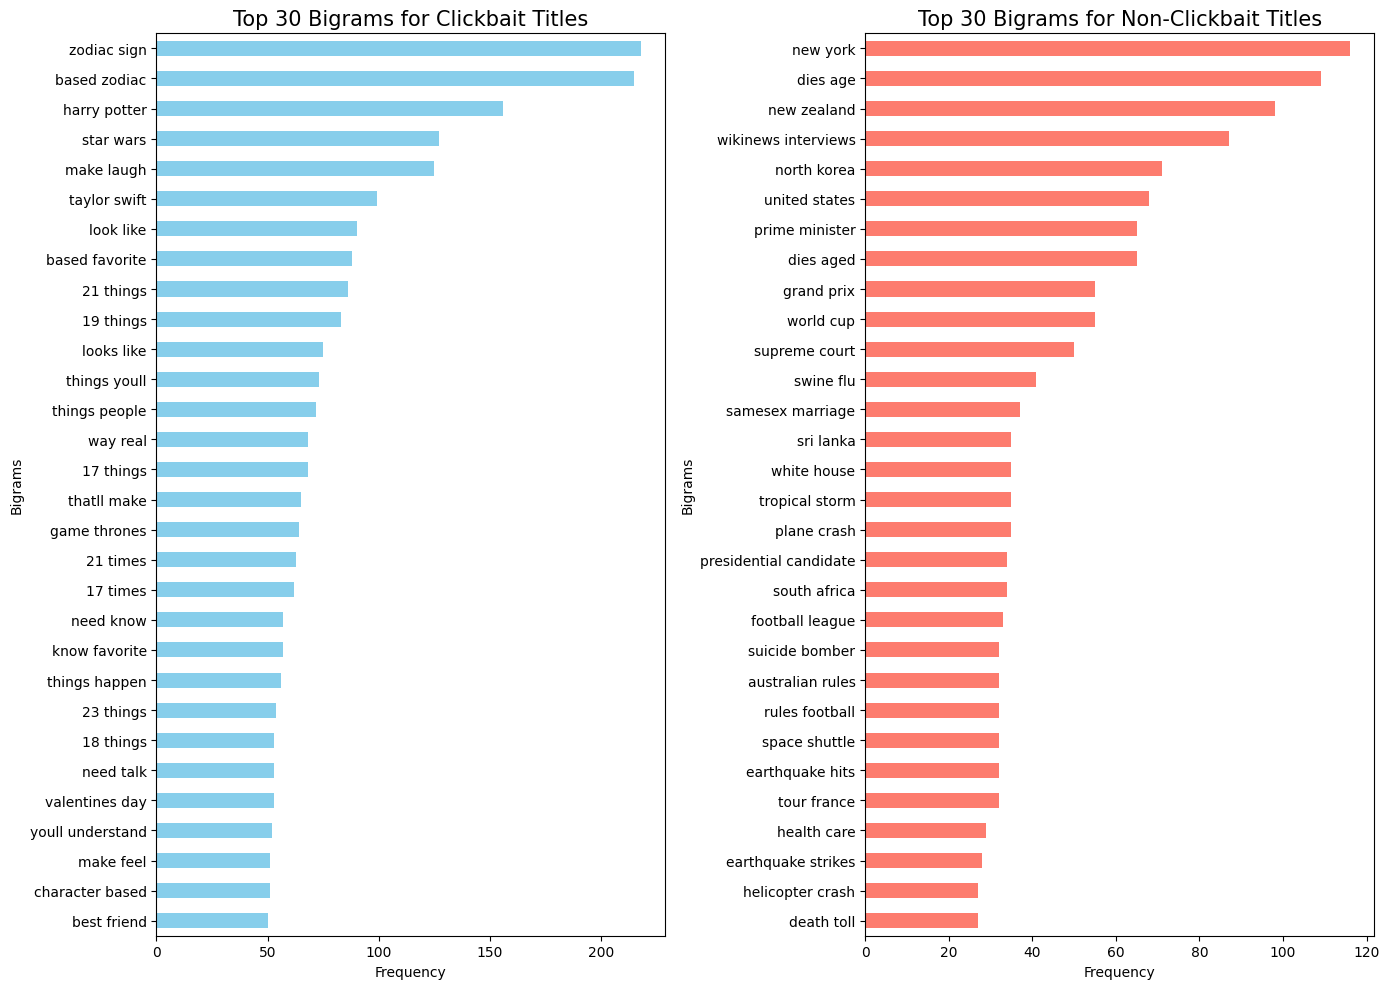

In [279]:
# top 40 bigrams using bar plot
fig, ax = plt.subplots(1, 2, figsize=(14, 10))

bigrams_cb.plot(kind='barh', ax=ax[0], color='#87ceeb')
ax[0].invert_yaxis()
ax[0].set_title('Top 30 Bigrams for Clickbait Titles', fontsize=15)
ax[0].legend().remove()
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Bigrams')

bigrams_non.plot(kind='barh', ax=ax[1], color='#fd7c6e')
ax[1].invert_yaxis()
ax[1].set_title('Top 30 Bigrams for Non-Clickbait Titles', fontsize=15)
ax[1].legend().remove()
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Bigrams')


plt.tight_layout()

In [25]:
# count headlines lengths
clickbates['words_num'] = clickbates['headline'].map(lambda x: len(x.split()))
non_clickbates['words_num'] = non_clickbates['headline'].map(lambda x: len(x.split()))

In [157]:
clickbates['words_num'].describe()

count    15999.000000
mean         9.938871
std          2.658622
min          1.000000
25%          8.000000
50%         10.000000
75%         12.000000
max         26.000000
Name: words_num, dtype: float64

In [93]:
non_clickbates['words_num'].describe()

count    16001.000000
mean         8.184238
std          2.222679
min          2.000000
25%          7.000000
50%          8.000000
75%          9.000000
max         21.000000
Name: words_num, dtype: float64

In [26]:
# merge data
headlines = pd.concat([clickbates, non_clickbates])
headlines = headlines.sample(frac = 1)
print(headlines.head())

MAX_LENGTH = max(headlines['words_num'])
print(MAX_LENGTH)

                                                headline  label  words_num
14218  rapid declines in manufacturing spread global ...      0          7
11780     its muscle car glory faded pontiac shrivels up      0          8
6349            how many of these logos do you recognize      1          8
15899  gary player says goodbye to masters after last...      0         11
6989   20 great carrie fisher tweets that arent about...      1         10
26


In [220]:
# check if starts with a digit
def starts_with_num(headline):
    if headline.startswith(('1','2','3','4','5','6','7','8','9')): 
        return 1
    else: 
        return 0

headlines['num_start'] = headlines['headline'].map(starts_with_num)

Text(0.5, 1.0, 'Headline starts with a number')

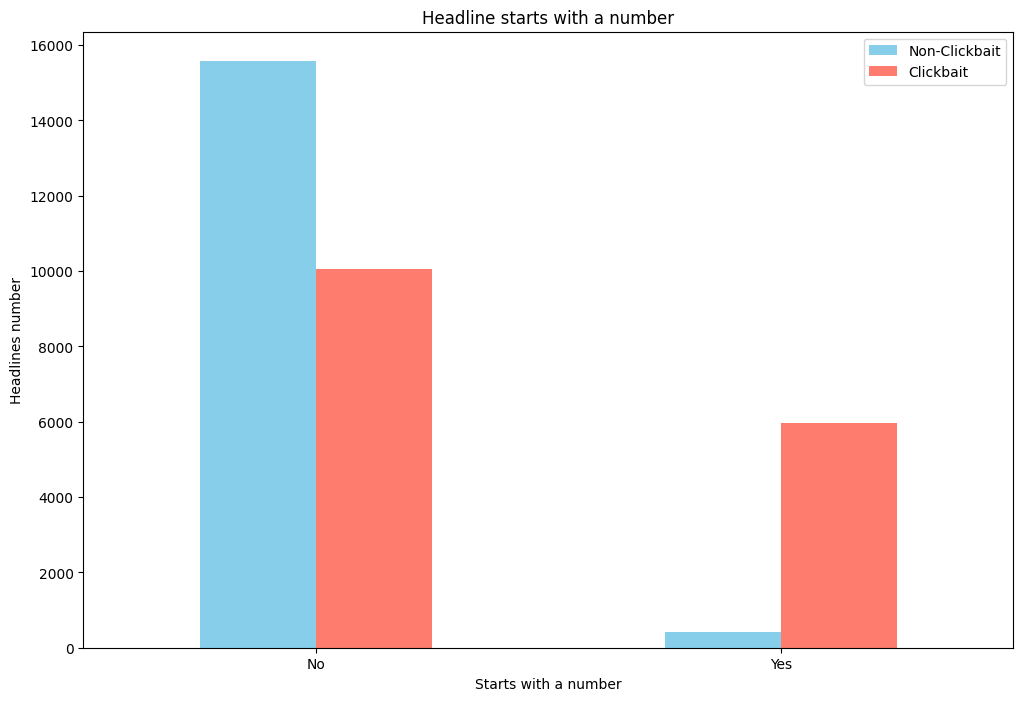

In [278]:
plt.figure(figsize=(12,8))
ax = plt.gca()
headlines.groupby('num_start')['label'].value_counts().unstack().plot.bar(ax=ax, rot=0, color=['#87ceeb', '#fd7c6e'])
plt.xlabel('Starts with a number')
plt.ylabel('Headlines number')
plt.legend(title=None,labels=['Non-Clickbait','Clickbait'])
ax.set_xticklabels(labels=['No','Yes'])
plt.title('Headline starts with a number')

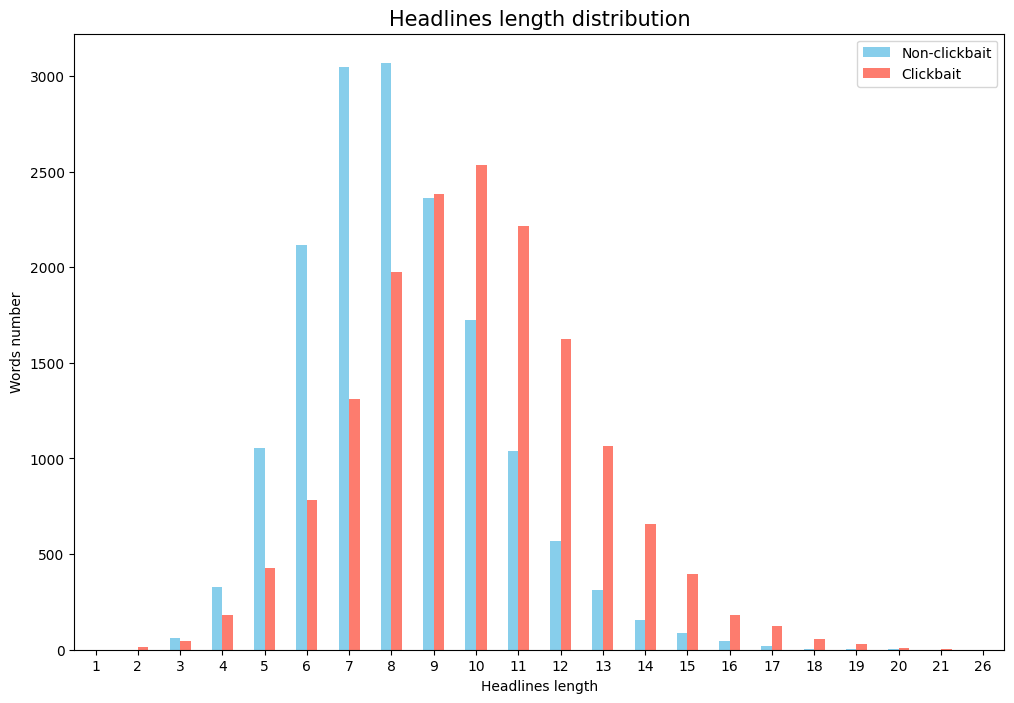

In [28]:
# distribution of headlines lengths
plt.figure(figsize=(12,8))
ax = plt.gca()
headlines.groupby('words_num')['label'].value_counts().unstack().plot.bar(ax=ax, rot=0, color=['#87ceeb', '#fd7c6e'])
plt.title('Headlines length distribution', fontsize=15)
plt.xlabel('Headlines length')
plt.ylabel('Words number')
ax.legend(['Non-clickbait', 'Clickbait'])

In [3]:
stopwords_list = stopwords.words('english')

# count number of stopwords
def stopwords_num(text):
    split_text = text.split()
    return len([word for word in split_text if word in stopwords_list])

In [223]:
# append to df number of stopwords in headlines
headlines['stopwords_num'] = headlines['headline'].map(stopwords_num)
headlines['stopwords_num'].describe()

count    32000.000000
mean         2.750656
std          1.851190
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         12.000000
Name: stopwords_num, dtype: float64

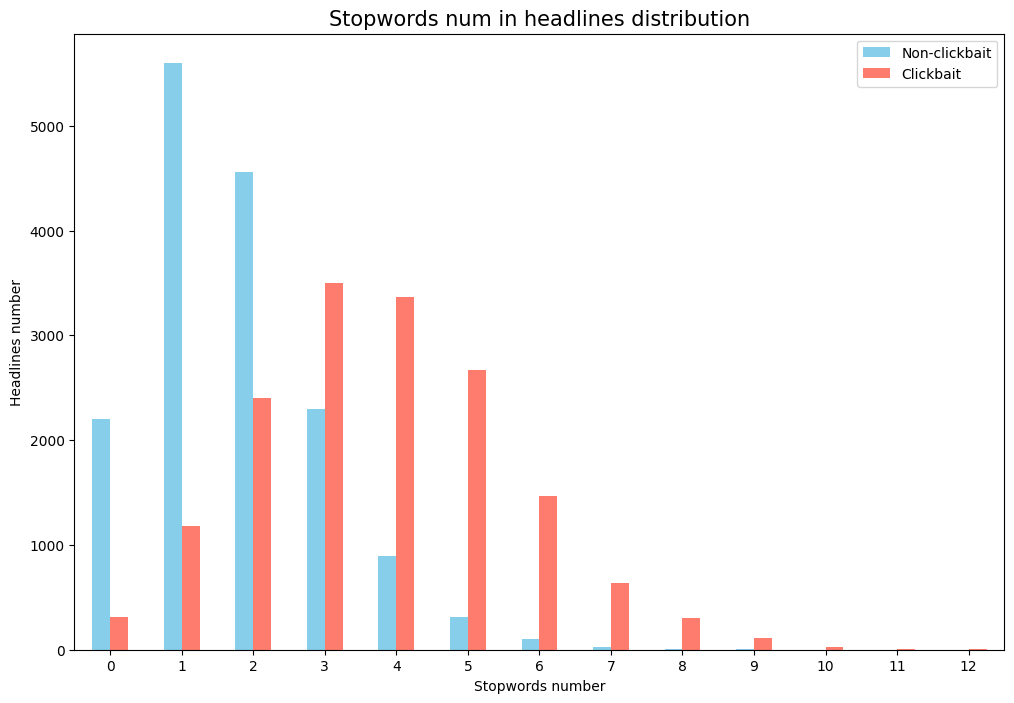

In [27]:
# distribution of stopwords num
plt.figure(figsize=(12,8))
ax = plt.gca()
headlines.groupby('stopwords_num')['label'].value_counts().unstack().plot.bar(ax=ax, rot=0, color=['#87ceeb', '#fd7c6e'])
plt.title('Stopwords num in headlines distribution', fontsize=15)
plt.xlabel('Stopwords number')
plt.ylabel('Headlines number')
ax.legend(['Non-clickbait', 'Clickbait'])

In [225]:
headlines.head()

headline  label  words_num  \
2517            130 dead after torrential rains in india      0          7   
593                   what will your old person hobby be      1          7   
14507  whats your personality type based on your opin...      1         10   
10036  telenor case stirs fear of russian court shopping      0          8   
11271              7 times we were all kidding ourselves      1          7   

       num_start  stopwords_num  
2517           1              2  
593            0              4  
14507          0              4  
10036          0              1  
11271          1              4

<Axes: title={'center': 'Heatmap for Correlation of numerical features'}>

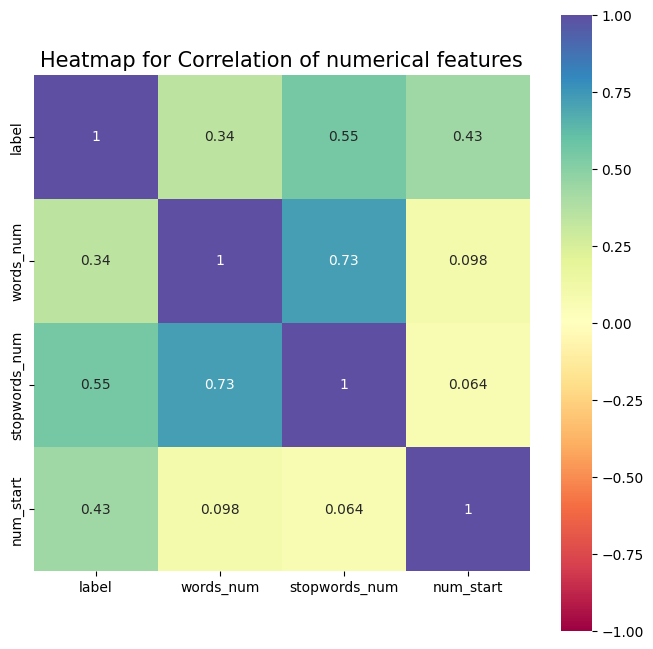

In [226]:
# correlation heatmap for new numerical features
plt.subplots(figsize=(8,8))
plt.title('Heatmap for Correlation of numerical features', fontsize=15)
sns.heatmap(headlines[['label', 'words_num', 'stopwords_num', 'num_start']].corr(), annot=True, vmin=-1, vmax=1, cmap='Spectral', square=True)

In [227]:
# save preprocessed data
with open('./data/preprocessed_featured.pkl','wb') as fp:
     pickle.dump(headlines, fp)

LSTM

Без удаления стоп-слов, без дополнительных признаков

In [59]:
with open('./data/preprocessed_merged.pkl','rb') as fp:
    data = pickle.load(fp)

In [61]:
X = data['headline']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print(X_test[:3])

5099          gilead to buy cv therapeutics for 14 billion
11793    san francisco reporter 90 covers science beat ...
1433     second turk dies from bird flu more suspected ...
Name: headline, dtype: object


In [62]:
print(len(X_train))
print(len(X_train[y_train == 1]))
print(len(X_train[y_train == 0]))

25600
12792
12808


In [50]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import keras
from keras.models import Sequential
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [63]:
# full vocabulary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X.tolist())

# # all headlines to numbers sequences
# textSequences = tokenizer.texts_to_sequences(X.tolist())
total_unique_words = len(tokenizer.word_counts)
print(total_unique_words)
print(tokenizer.word_index)

24771
{'to': 1, 'in': 2, 'the': 3, 'of': 4, 'you': 5, 'a': 6, 'for': 7, 'and': 8, 'on': 9, 'your': 10, 'is': 11, 'are': 12, 'that': 13, 'this': 14, 'with': 15, 'at': 16, 'will': 17, 'us': 18, 'from': 19, 'new': 20, 'about': 21, 'what': 22, 'who': 23, 'people': 24, 'things': 25, 'how': 26, 'which': 27, 'as': 28, 'can': 29, 'we': 30, 'make': 31, 'know': 32, 'by': 33, 'be': 34, 'after': 35, '17': 36, 'do': 37, '21': 38, 'should': 39, 'have': 40, 'these': 41, 'based': 42, 'actually': 43, '19': 44, 'all': 45, 'it': 46, 'over': 47, 'their': 48, 'times': 49, 'up': 50, 'an': 51, 'was': 52, 'its': 53, 'if': 54, 'first': 55, 'out': 56, 'like': 57, '2015': 58, 'most': 59, 'best': 60, 'more': 61, 'or': 62, 'one': 63, 'when': 64, 'life': 65, 'need': 66, 'heres': 67, 'has': 68, 'his': 69, 'world': 70, 'just': 71, 'time': 72, '15': 73, 'dead': 74, '23': 75, '18': 76, 'her': 77, 'get': 78, 'killed': 79, 'dies': 80, 'ever': 81, 'every': 82, 'day': 83, 'two': 84, 'were': 85, 'president': 86, 'not': 87, 

In [64]:
VOCAB_SIZE = round(total_unique_words * 0.5) # 40%
print(VOCAB_SIZE)

12386


In [65]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X.tolist())
total_unique_words = len(tokenizer.word_counts)
print(total_unique_words)
print(tokenizer.word_index)

24771
{'to': 1, 'in': 2, 'the': 3, 'of': 4, 'you': 5, 'a': 6, 'for': 7, 'and': 8, 'on': 9, 'your': 10, 'is': 11, 'are': 12, 'that': 13, 'this': 14, 'with': 15, 'at': 16, 'will': 17, 'us': 18, 'from': 19, 'new': 20, 'about': 21, 'what': 22, 'who': 23, 'people': 24, 'things': 25, 'how': 26, 'which': 27, 'as': 28, 'can': 29, 'we': 30, 'make': 31, 'know': 32, 'by': 33, 'be': 34, 'after': 35, '17': 36, 'do': 37, '21': 38, 'should': 39, 'have': 40, 'these': 41, 'based': 42, 'actually': 43, '19': 44, 'all': 45, 'it': 46, 'over': 47, 'their': 48, 'times': 49, 'up': 50, 'an': 51, 'was': 52, 'its': 53, 'if': 54, 'first': 55, 'out': 56, 'like': 57, '2015': 58, 'most': 59, 'best': 60, 'more': 61, 'or': 62, 'one': 63, 'when': 64, 'life': 65, 'need': 66, 'heres': 67, 'has': 68, 'his': 69, 'world': 70, 'just': 71, 'time': 72, '15': 73, 'dead': 74, '23': 75, '18': 76, 'her': 77, 'get': 78, 'killed': 79, 'dies': 80, 'ever': 81, 'every': 82, 'day': 83, 'two': 84, 'were': 85, 'president': 86, 'not': 87, 

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=MAX_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_LENGTH)

In [71]:
model = Sequential()
model.add(Input(shape=(MAX_LENGTH,)))
model.add(Embedding(VOCAB_SIZE, 32))
model.add(LSTM(32, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 26, 32)         │       396,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 26, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,705 (1.54 MB)

 Trainable params: 404,705 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-8,
        patience=3,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='.weights.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

In [72]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=512, validation_data=(X_test, y_test), epochs=20, callbacks=callbacks)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7799 - loss: 0.6534
Epoch 1: val_accuracy did not improve from 0.97516
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.7816 - loss: 0.6519 - val_accuracy: 0.9153 - val_loss: 0.3482
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9270 - loss: 0.2821
Epoch 2: val_accuracy did not improve from 0.97516
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9274 - loss: 0.2808 - val_accuracy: 0.9628 - val_loss: 0.1280
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9684 - loss: 0.1085
Epoch 3: val_accuracy did not improve from 0.97516
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9685 - loss: 0.1082 - val_accuracy: 0.9700 - val_loss: 0.1011
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9819 - loss: 0.0700
Epoch 4: val_accuracy did not improve from 0.97516
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.9819 - loss: 0.0700 - val_accuracy: 0.9730 - val_los

In [73]:
y_pred = [round(i[0]) for i in model.predict(X_test)]

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


Recall of the model is 0.96
Precision of the model is 0.98


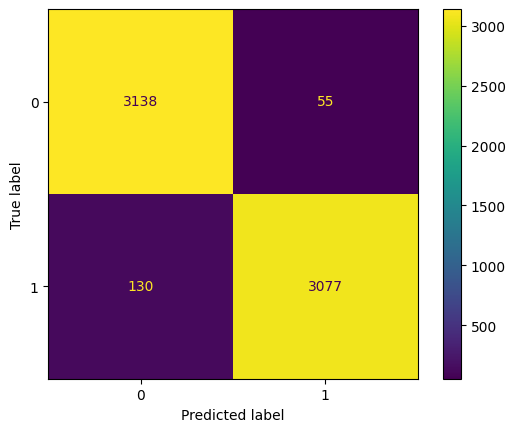

In [74]:
cm = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

Удалим стоп слова, без дополнительных признаков

In [11]:
with open('./data/preprocessed_merged.pkl','rb') as fp:
    data = pickle.load(fp)

data["headline"] = data["headline"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_list)]))

In [12]:
X = data['headline']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [15]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X.tolist())
total_unique_words = len(tokenizer.word_counts)
print(total_unique_words)
print(tokenizer.word_index)

24640
{'us': 1, 'new': 2, 'people': 3, 'things': 4, 'make': 5, 'know': 6, '17': 7, '21': 8, 'based': 9, 'actually': 10, '19': 11, 'times': 12, 'first': 13, 'like': 14, '2015': 15, 'best': 16, 'one': 17, 'life': 18, 'need': 19, 'heres': 20, 'world': 21, 'time': 22, '15': 23, 'dead': 24, '23': 25, '18': 26, 'get': 27, 'killed': 28, 'dies': 29, 'ever': 30, 'day': 31, 'every': 32, 'two': 33, 'president': 34, 'uk': 35, 'says': 36, 'youre': 37, 'love': 38, 'real': 39, 'zodiac': 40, 'british': 41, 'everyone': 42, 'favorite': 43, '22': 44, 'australian': 45, 'man': 46, 'kills': 47, 'way': 48, '16': 49, 'ways': 50, 'wins': 51, 'photos': 52, 'years': 53, 'sign': 54, 'would': 55, '13': 56, 'game': 57, 'show': 58, 'women': 59, 'obama': 60, 'pictures': 61, 'well': 62, 'tweets': 63, 'police': 64, 'star': 65, 'understand': 66, 'character': 67, 'youll': 68, 'christmas': 69, '24': 70, 'really': 71, 'halloween': 72, 'video': 73, 'reasons': 74, 'guess': 75, 'never': 76, 'movie': 77, 'court': 78, 'china': 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=MAX_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_LENGTH)

In [28]:
model = Sequential()
model.add(Input(shape=(MAX_LENGTH,)))
model.add(Embedding(VOCAB_SIZE, 32))
model.add(LSTM(32, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 26, 32)         │       396,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 26, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,705 (1.54 MB)

 Trainable params: 404,705 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=512, validation_data=(X_test, y_test), epochs=20, callbacks=callbacks)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6508 - loss: 0.6813
Epoch 1: val_accuracy improved from -inf to 0.94109, saving model to .weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - accuracy: 0.6533 - loss: 0.6807 - val_accuracy: 0.9411 - val_loss: 0.5246
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9170 - loss: 0.4048
Epoch 2: val_accuracy improved from 0.94109 to 0.94609, saving model to .weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9172 - loss: 0.4030 - val_accuracy: 0.9461 - val_loss: 0.1920
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9597 - loss: 0.1533
Epoch 3: val_accuracy improved from 0.94609 to 0.95203, saving model to .weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.9597 - loss: 0.1530 - val_accuracy: 0.9520 - val_loss: 0.1336
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9760 - loss: 0.0949
Epoch 4: val_accuracy improved from 0.95203 to 0.95453, sav

In [31]:
y_pred = [round(i[0]) for i in model.predict(X_test)]

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


Recall of the model is 0.95
Precision of the model is 0.96


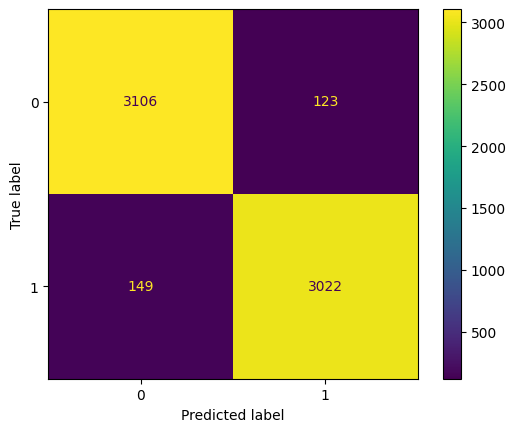

In [32]:
cm = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

С добавленными признаками, стоп-слова не убраны

In [75]:
with open('./data/preprocessed_featured.pkl','rb') as fp:
    data = pickle.load(fp)

X = data[['headline', 'words_num', 'stopwords_num', 'num_start']]
y = data['label']

In [78]:
data

headline  label  words_num  \
2517            130 dead after torrential rains in india      0          7   
593                   what will your old person hobby be      1          7   
14507  whats your personality type based on your opin...      1         10   
10036  telenor case stirs fear of russian court shopping      0          8   
11271              7 times we were all kidding ourselves      1          7   
...                                                  ...    ...        ...   
3633        football fulham fc sacks coach chris coleman      0          7   
10870                      social networks eclipse email      0          4   
14021  former north korean agent makes public appearance      0          7   
12236  uk soldier shot dead in afghanistan number of ...      0         16   
12081  elections canada stands by decision muslims no...      0         13   

       num_start  stopwords_num  
2517           1              2  
593            0              4  
14507          0              4  
10036          0              1  
11271          1              4  
...          ...            ...  
3633           0              0  
10870          0              0  
14021          0              0  
12236          0              4  
12081          0              4  

[32000 rows x 5 columns]

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train_heads = X_train['headline']
X_test_heads = X_test['headline']

X_train_heads = tokenizer.texts_to_sequences(X_train_heads)
X_test_heads = tokenizer.texts_to_sequences(X_test_heads)

X_train_heads = pad_sequences(X_train_heads, maxlen=MAX_LENGTH)
X_test_heads = pad_sequences(X_test_heads, maxlen=MAX_LENGTH)

In [77]:
print(X_train_heads[:2])

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0   469  2990
    469  7905]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0   179   135     5   951     5    85     3 11014
      4  4118]]


In [79]:
# Scale engineered features
ss = StandardScaler()
X_train_num = ss.fit_transform(X_train[['words_num', 'stopwords_num', 'num_start']])
X_test_num = ss.transform(X_test[['words_num', 'stopwords_num', 'num_start']])

X_train = np.hstack([X_train_heads, X_train_num])
X_test = np.hstack([X_test_heads, X_test_num])

In [81]:
model = Sequential()
model.add(Input(shape=(MAX_LENGTH + 3,)))
model.add(Embedding(VOCAB_SIZE, 32))
model.add(LSTM(32, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 29, 32)         │       396,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 29, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_6          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,705 (1.54 MB)

 Trainable params: 404,705 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=512, validation_data=(X_test, y_test), epochs=20, callbacks=callbacks)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6961 - loss: 0.6490
Epoch 1: val_accuracy did not improve from 0.97531
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 108ms/step - accuracy: 0.6982 - loss: 0.6474 - val_accuracy: 0.9322 - val_loss: 0.3227
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9431 - loss: 0.2567
Epoch 2: val_accuracy did not improve from 0.97531
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.9433 - loss: 0.2556 - val_accuracy: 0.9677 - val_loss: 0.1219
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9733 - loss: 0.1070
Epoch 3: val_accuracy did not improve from 0.97531
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.9734 - loss: 0.1068 - val_accuracy: 0.9741 - val_loss: 0.0878
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9846 - loss: 0.0653
Epoch 4: val_accuracy did not improve from 0.97531
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9846 - loss: 0.0652 - val_accuracy: 0.9736 - val_los

In [83]:
y_pred = [round(i[0]) for i in model.predict(X_test)]

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [84]:
cm = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.3f}".format(recall))
print("Precision of the model is {:.3f}".format(precision))

Recall of the model is 0.972
Precision of the model is 0.982


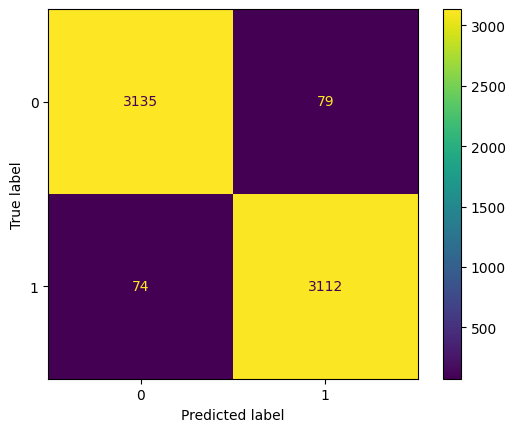

In [258]:
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

In [40]:
with open('./data/preprocessed_featured.pkl','rb') as fp:
    data = pickle.load(fp)

X = data[['headline', 'words_num', 'stopwords_num', 'num_start']]
y = data['label']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train_heads = X_train['headline']
X_test_heads = X_test['headline']

X_train_heads = tokenizer.texts_to_sequences(X_train_heads)
X_test_heads = tokenizer.texts_to_sequences(X_test_heads)

X_train_heads = pad_sequences(X_train_heads, maxlen=MAX_LENGTH)
X_test_heads = pad_sequences(X_test_heads, maxlen=MAX_LENGTH)

In [42]:
# Scale engineered features
ss = StandardScaler()
X_train_num = ss.fit_transform(X_train[['words_num', 'stopwords_num', 'num_start']])
X_test_num = ss.transform(X_test[['words_num', 'stopwords_num', 'num_start']])

X_train = np.hstack([X_train_heads, X_train_num])
X_test = np.hstack([X_test_heads, X_test_num])

In [43]:
model = Sequential()
model.add(Input(shape=(MAX_LENGTH + 3,)))
model.add(Embedding(VOCAB_SIZE, 32))
model.add(LSTM(32, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 29, 32)         │       396,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 29, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,705 (1.54 MB)

 Trainable params: 404,705 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=512, validation_data=(X_test, y_test), epochs=20, callbacks=callbacks)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6966 - loss: 0.6722
Epoch 1: val_accuracy did not improve from 0.95750
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.6986 - loss: 0.6713 - val_accuracy: 0.8894 - val_loss: 0.4502
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8819 - loss: 0.3855
Epoch 2: val_accuracy did not improve from 0.95750
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.8826 - loss: 0.3839 - val_accuracy: 0.9431 - val_loss: 0.1764
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9604 - loss: 0.1456
Epoch 3: val_accuracy did not improve from 0.95750
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.9604 - loss: 0.1454 - val_accuracy: 0.9573 - val_loss: 0.1280
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9766 - loss: 0.0914
Epoch 4: val_accuracy improved from 0.95750 to 0.96172, saving model to .weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9766 - los

In [45]:
y_pred = [round(i[0]) for i in model.predict(X_test)]

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


Recall of the model is 0.959
Precision of the model is 0.962


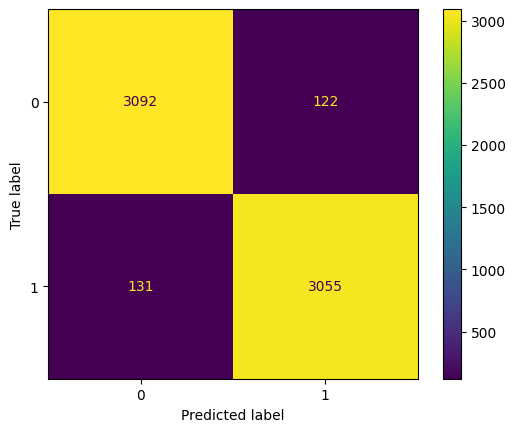

In [46]:
cm = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.3f}".format(recall))
print("Precision of the model is {:.3f}".format(precision))

disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()